# Fruit classifier - ConvNeXt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9419882a-4425-007d-2b58-683dbd9ea7fc)


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

import datetime
import os
import time
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [ ]:
# Hyperparams

IMAGE_SIZE = [224, 224]
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224_fe/1"
BATCH_SIZE = 32  


# Prepare sample data for feature extractor and classifier modelling

ImageDataGenerator used to load images into memory

```

In [ ]:
# https://github.com/keras-team/keras-applications
img_height = img_width = 224 # 224 is also ok
channels = 3

In [ ]:
# Prepare labels, used during tests
labels = [ 'Apple Braeburn', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
          'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
          'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
          'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi' ]    

## Prepare dataset - training and validation

In [ ]:
path = "/content/drive/MyDrive/data/fruit-360/Training40"

import glob
import pandas as pd


data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df_train = pd.DataFrame(data, columns=['filename', 'class_name'])

df_train['class_name'] = df_train['class_name'].astype('category')
df_train['class'] = df_train['class_name'].cat.codes

#shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)

print(df_train.head())
print(len(df_train))
df_train.dtypes

                                            filename  class_name  class
0  /content/drive/MyDrive/data/fruit-360/Training...       Guava     35
1  /content/drive/MyDrive/data/fruit-360/Training...         Fig     29
2  /content/drive/MyDrive/data/fruit-360/Training...   Corn Husk     24
3  /content/drive/MyDrive/data/fruit-360/Training...  Clementine     21
4  /content/drive/MyDrive/data/fruit-360/Training...     Apricot      1
20369


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
path = "/content/drive/MyDrive/data/fruit-360/Validation40"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df_val = pd.DataFrame(data, columns=['filename', 'class_name'])

df_val['class_name'] = df_val['class_name'].astype('category')
df_val['class'] = df_val['class_name'].cat.codes

#shuffle
df_val = df_val.sample(frac=1).reset_index(drop=True)

print(df_val.head())
print(len(df_val))
df_val.dtypes

                                            filename    class_name  class
0  /content/drive/MyDrive/data/fruit-360/Validati...         Cocos     22
1  /content/drive/MyDrive/data/fruit-360/Validati...      Cherry 2     15
2  /content/drive/MyDrive/data/fruit-360/Validati...  Avocado ripe      3
3  /content/drive/MyDrive/data/fruit-360/Validati...           Fig     29
4  /content/drive/MyDrive/data/fruit-360/Validati...      Cherry 2     15
3422


filename        object
class_name    category
class             int8
dtype: object

# Data Pipeline

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
num_classes = 2
batch_size = 32

# # Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3) # tf.image.decode_png
  image_resized = tf.image.resize(image_decoded, size=[img_rows, img_cols], method="bicubic")
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  image_resized = (image_resized - MEAN) / STD  # normalization
  return image_resized, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int64) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int64) ))
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
num_train = tf.data.experimental.cardinality(train_dataset)

train_dataset, val_dataset

(<BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>)

# LR Scheduler Utility

In [ ]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

# Model Utility

In [ ]:
def get_model(model_path=MODEL_PATH, res=224, num_classes=40):
    hub_layer = hub.KerasLayer(model_path, trainable=True)

    model = keras.Sequential(
        [
            InputLayer((res, res, 3)),
            hub_layer,
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model

In [ ]:
# Assemble the model
model = get_model(MODEL_PATH, num_classes=40)
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 768)               27820128  
                                                                 
 dense (Dense)               (None, 40)                30760     
                                                                 
Total params: 27,850,888
Trainable params: 27,850,888
Non-trainable params: 0
_________________________________________________________________


# Training Hyperparameters

In [ ]:
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)

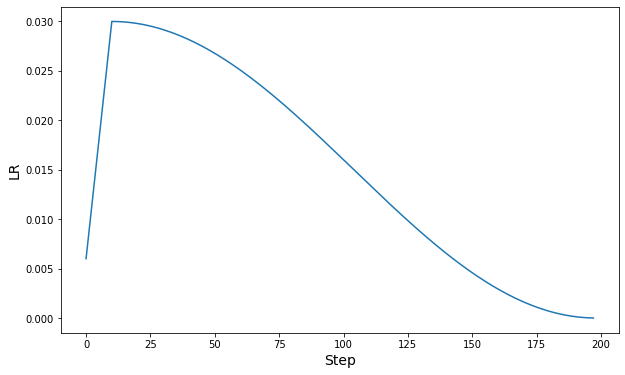

In [ ]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Prepare Classifier model

In [ ]:
optimizer = SGD(scheduled_lrs)
loss = SparseCategoricalCrossentropy()

In [ ]:
# Assemble the model
model = get_model(MODEL_PATH)

# compile the model
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=["accuracy"], 
              run_eagerly=False)

In [ ]:

history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    epochs=5)

Epoch 1/5
636/636 [==============================] - 2863s 4s/step - loss: 0.7091 - accuracy: 0.9188 - val_loss: 0.5729 - val_accuracy: 0.9475
Epoch 2/5
636/636 [==============================] - 524s 805ms/step - loss: 0.4158 - accuracy: 0.9903 - val_loss: 0.5729 - val_accuracy: 0.9475
Epoch 3/5
636/636 [==============================] - 509s 783ms/step - loss: 0.4157 - accuracy: 0.9904 - val_loss: 0.5729 - val_accuracy: 0.9475
Epoch 4/5
636/636 [==============================] - 508s 782ms/step - loss: 0.4159 - accuracy: 0.9903 - val_loss: 0.5729 - val_accuracy: 0.9475
Epoch 5/5
636/636 [==============================] - 509s 782ms/step - loss: 0.4159 - accuracy: 0.9903 - val_loss: 0.5729 - val_accuracy: 0.9475


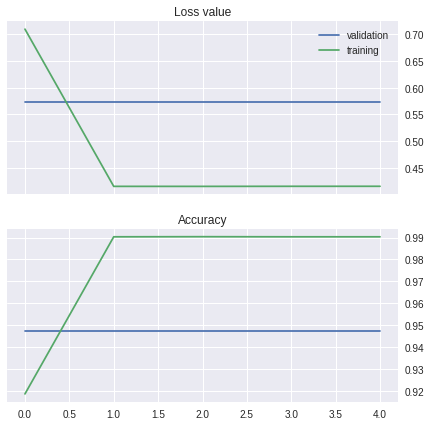

In [ ]:
plt.style.use('seaborn')                   
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   


plt.figure()
plt.subplot(211)
plt.plot(history.history['val_loss'], label="validation")
plt.plot(history.history['loss'],label="training")
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(history.history['val_accuracy'],label="validation")
plt.plot(history.history['accuracy'],label="training")
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

---------------------------

------------------------

# Test on unseen data

## Prepare dataset - testing

In [ ]:
path = "/content/drive/MyDrive/data/fruit-360/Testing40"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df_test = pd.DataFrame(data, columns=['filename', 'class_name'])

df_test['class_name'] = df_test['class_name'].astype('category')
df_test['class'] = df_test['class_name'].cat.codes

#shuffle
df_test = df_test.sample(frac=1).reset_index(drop=True)

print(df_test.head())
print(len(df_test))
df_test.dtypes

                                            filename         class_name  class
0  /content/drive/MyDrive/data/fruit-360/Testing4...  Cherry Wax Yellow     19
1  /content/drive/MyDrive/data/fruit-360/Testing4...           Cherry 2     15
2  /content/drive/MyDrive/data/fruit-360/Testing4...           Chestnut     20
3  /content/drive/MyDrive/data/fruit-360/Testing4...       Cactus fruit      9
4  /content/drive/MyDrive/data/fruit-360/Testing4...        Ginger Root     30
3410


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int64) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
test_dataset

<BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>

## Test

In [ ]:
# Predictions

# feed the images directly to the combined model
pred = model.predict(test_dataset)

# convert from probabilities to labels
pred_label_index = pred.argmax(axis=1) 

In [ ]:
pred_label_index.shape

(3392,)

In [ ]:
# Reference
# labels: ['Apple Braeburn', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
#          'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
#          'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
#          'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi']

In [ ]:
# check label indexes
print( np.sort( df_test['class'].unique() ) )  

# prepare truth data for confusion matrix use
truth = df_test['class'][:3392].copy()
print( truth.shape )

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(3392,)


In [ ]:
print(confusion_matrix(truth, pred_label_index))
print(classification_report(truth, pred_label_index, target_names=labels))

[[77  0  0 ...  0  0  0]
 [ 0 81  0 ...  0  0  0]
 [ 0  0 69 ...  0  0  0]
 ...
 [ 0  0  0 ... 82  0  0]
 [ 0  0  0 ...  0 82  0]
 [ 0  0  0 ...  0  0 78]]
                    precision    recall  f1-score   support

    Apple Braeburn       1.00      0.96      0.98        80
           Apricot       1.00      1.00      1.00        81
           Avocado       1.00      1.00      1.00        69
      Avocado ripe       0.95      1.00      0.98        82
            Banana       0.99      0.85      0.91        81
Banana Lady Finger       0.99      0.99      0.99        76
        Banana Red       1.00      1.00      1.00        81
          Beetroot       0.73      0.69      0.71        75
         Blueberry       0.84      0.69      0.76        77
      Cactus fruit       1.00      1.00      1.00        83
      Cantaloupe 1       1.00      1.00      1.00        82
      Cantaloupe 2       0.91      1.00      0.95        81
         Carambula       0.57      1.00      0.73        82
   

In [ ]:
model.save("/content/drive/MyDrive/data/fruit-360/convnext_model.h5")

------------------------------------

-----------------------------